In [1]:
%reset -f

## Lets import some useful packages

In [2]:
import warnings
warnings.filterwarnings("ignore")
import random
from copy import deepcopy as dp

import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, TensorBoard
from keras.initializers import RandomNormal as RN
from keras.utils.vis_utils import model_to_dot






from tqdm import *
import os 
from os import system
from PIL import Image
from IPython.display import SVG
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score

Using TensorFlow backend.


## Some parameters

In [3]:
size = 128
data_train_path_target = "data_airbus_defi/train/"
data_test_path = "data_airbus_defi/test/"
input_shape = (size, size, 3)

## Loading data. Numpy arrays

In [4]:
PATH = os.getcwd()

###############
# SIZE LOADED #
###############

full = True
some = True
if full:
    training_size = float("inf")
    testing_size = float("inf")
elif some:
    training_size = 1000
    testing_size = float("inf")
else:
    training_size = 10
    testing_size = 10
    

    
#########
# TRAIN #
#########

train_path = PATH +"/" + data_train_path_target + "target/"
train_data_target = os.listdir(train_path)
x_train = []
tdt = 0
for sample in (train_data_target):
    img_path = train_path+sample
    x = image.load_img(img_path)
    x_train.append(np.array(x))
    tdt += 1
    if tdt > training_size:
        break

train_path = PATH +"/" + data_train_path_target + "other/"
train_data_other = os.listdir(train_path)
x_train2 = []
tdo = 0
for sample in (train_data_other):
    img_path = train_path+sample
    x = image.load_img(img_path)
    # preprocessing if required
    x_train2.append(np.array(x))
    tdo += 1
    if tdo > training_size:
        break

        
########
# TEST #
########

test_path = PATH+'/data_airbus_defi/test/'
test_data = os.listdir(test_path)
x_test = []
td = 0
output = pd.DataFrame(columns=["name"])
test_data = [str(x) + ".jpg" for x in range(len(test_data))]
for sample in (test_data):
    output.append({"name": sample},ignore_index=True)
    #print(sample)
    img_path = test_path+sample
    x = image.load_img(img_path)
    # preprocessing if required
    x_test.append(np.array(x))
    td+=1
    if td > testing_size:
        break
    

# finally converting list into numpy array
x_train = np.array(x_train)
x_train2 = np.array(x_train2)
x_test = np.array(x_test) / 255.
XTRAIN = np.concatenate((x_train, x_train2), axis=0) / 255.

In [5]:
system('say Data chargée!')

0

In [6]:
print("Input data shape")
print(x_train.shape)
print(x_train2.shape)
print(XTRAIN.shape)

Input data shape
(32966, 128, 128, 3)
(35252, 128, 128, 3)
(68218, 128, 128, 3)


## Lablelling data

In [9]:
train_label1 = np.array([1] * x_train.shape[0] + [0] * x_train2.shape[0])

Suffling data. Not (totally) sure it is useful.

Quite ong when we use every data

In [10]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
XTRAIN, train_labels = unison_shuffled_copies(XTRAIN,train_label1)
#IMTRAIN, im_labels = unison_shuffled_copies(IMTRAIN,train_labels)
#XTRAIN, train_labels  = zip(*random.shuffle(list(zip(XTRAIN,train_label1))))

In [11]:
system('say Data mélangée!')

0

## Useful (?) functions

In [31]:
def plotModel(model):
    SVG(model_to_dot(model).create(prog='dot', format='svg'))
def plotLearning(history):
    plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.close()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.close()
    
    
    
    plt.plot(history.history['val_acc'])
    plt.title('Validation Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('Epoch')
    plt.show()
    plt.close()
    
    
def saveModel(model, name):
    path = "model/" + name 
    model_json = model.to_json()
    with open(path + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(path + ".h5")
    print("Saved model")

def loadModel( name):
    path = "model/" + name 
    json_file = open(path + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path + ".h5")
    #loaded_model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])
    print("Loaded model from disk")
    return loaded_model
    
    

    
def soumissionCSV(prediction, name):
    global test_data
    X = pd.DataFrame()
    X["name"] = test_data
    X["prediction"] = prediction
    X.set_index("name", inplace=True)
    X.to_csv(name + ".csv", sep=";")
    print("CSV file written")
    
def cut_half(x):
    if x < .5:
        return 0
    else:
        return 1
    
def prediction_from_model(model):
    global x_test
    pred = model.predict(x_test)
    prediction = [cut_half(x) for x in pred]
    print("some predictions")
    print(prediction[:9])
    return prediction

## Model generator

In [18]:
def cnn(n_layers):
    global input_shape
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN

    # Define hyperparamters
    MIN_NEURONS = 12
    MAX_NEURONS = 32
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=input_shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    # Add output layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [20]:
modelCNN = cnn(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 126, 12)      336       
_________________________________________________________________
activation_16 (Activation)   (None, 126, 126, 12)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 124, 124, 20)      2180      
_________________________________________________________________
activation_17 (Activation)   (None, 124, 124, 20)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 122, 122, 28)      5068      
_________________________________________________________________
activation_18 (Activation)   (None, 122, 122, 28)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 28)        0         
__________

## The model. Finally !

In [21]:
trained = False

epochs = 10
validation_split = .1
conv2Dsize = 24
pool_size = (3,3)
fulSize = 64


modelBW = Sequential()
modelBW.add(Conv2D(conv2Dsize, pool_size, input_shape = input_shape, activation = 'relu'))


modelBW.add(Conv2D(12, pool_size, activation = 'relu'))
modelBW.add(Conv2D( 6, pool_size, activation = 'relu'))


modelBW.add(MaxPooling2D(pool_size = pool_size))
#model.add(Dropout(0.2))
modelBW.add(Conv2D(conv2Dsize, (3, 3), activation = 'relu'))
modelBW.add(MaxPooling2D(pool_size = pool_size))
#model.add(Dropout(0.2))
modelBW.add(Flatten())
modelBW.add(Dense(units = fulSize, activation = 'sigmoid'))
modelBW.add(Dense(units = 1, activation = 'sigmoid'))

modelBW.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
modelBW.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 24)      672       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 12)      2604      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 6)       654       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 40, 40, 6)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 38, 38, 24)        1320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 24)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3456)              0         
__________

## Maybe we can use Tensorboard to vizualize learning ?


In [ ]:
"""
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=0, mode='auto')
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "TF" + now
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)
callbacks = [early_stopping, tensorboard]
model.fit(XTRAIN, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=0)
"""

## Learning

Train on 61396 samples, validate on 6822 samples
Epoch 1/10
61396/61396 [==============================] - 3221s 52ms/step - loss: 0.2462 - acc: 0.9050 - val_loss: 0.1765 - val_acc: 0.9317
Epoch 2/10
61396/61396 [==============================] - 2589s 42ms/step - loss: 0.1498 - acc: 0.9404 - val_loss: 0.1455 - val_acc: 0.9433
Epoch 3/10
61396/61396 [==============================] - 2536s 41ms/step - loss: 0.1147 - acc: 0.9555 - val_loss: 0.1231 - val_acc: 0.9524
Epoch 4/10
61396/61396 [==============================] - 2636s 43ms/step - loss: 0.0889 - acc: 0.9667 - val_loss: 0.1335 - val_acc: 0.9537
Epoch 5/10
61396/61396 [==============================] - 2949s 48ms/step - loss: 0.0652 - acc: 0.9758 - val_loss: 0.1541 - val_acc: 0.9553
Epoch 6/10
61396/61396 [==============================] - 2936s 48ms/step - loss: 0.0501 - acc: 0.9812 - val_loss: 0.1675 - val_acc: 0.9509
Epoch 7/10
61396/61396 [==============================] - 2937s 48ms/step - loss: 0.0391 - acc: 0.9866 - val_lo

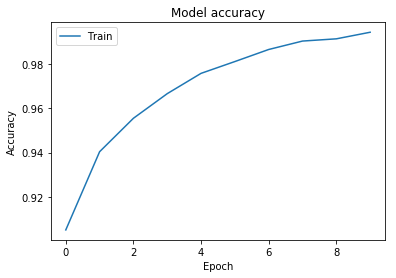

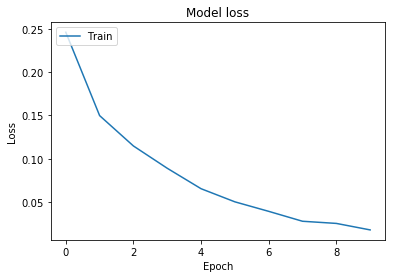

In [22]:
history = modelCNN.fit(XTRAIN, train_labels, epochs=epochs, verbose=1, validation_split=validation_split)

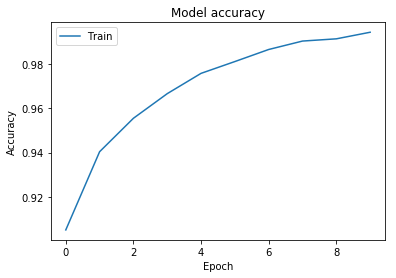

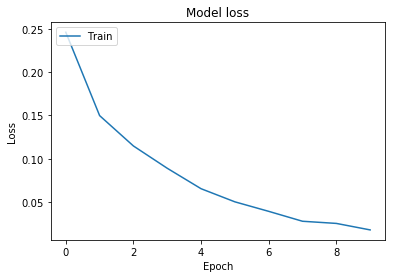

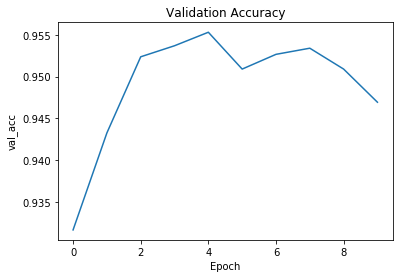

In [32]:
plotLearning(history)

## Prediction

In [23]:
prediction = prediction_from_model(modelCNN)

some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


## Writting output

In [24]:
today = str(datetime.today())[:16]
soumissionCSV(prediction, today)

CSV file written


In [25]:
system('say On est bon!')

0

In [26]:
print("Proportion of windmills")
sum(prediction)/ len(prediction)

Proportion of windmills


0.4866322701688555

In [27]:
saveModel(modelCNN, today)

Saved model


## Loading old models

In [22]:
loadedModel = loadModel("1erNovembre3")
pred = prediction_from_model(loadedModel)

Loaded model from disk
some predictions
[1, 0, 1, 0, 1, 1, 0, 1, 1]


-------

## One model that was good

In [ ]:
epochs = 50
validation_split = .1
conv2Dsize = 12
pool_size = (2,2)


modelBW = Sequential()
modelBW.add(Conv2D(conv2Dsize, (5), 
                  padding="same", 
                  input_shape=input_shape))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

# second set of CONV => RELU => POOL layers
modelBW.add(Conv2D(conv2Dsize, (5, 5), padding="same"))
modelBW.add(Activation("relu"))
modelBW.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
#model.add(Dropout(0.2)) ???



#first (and only) set of FC => RELU layers
modelBW.add(Flatten())
modelBW.add(Dense(2))
modelBW.add(Activation("sigmoid"))

# softmax classifier
modelBW.add(Dense(1))
modelBW.add(Activation("relu"))
modelBW.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['accuracy'])

